# 'Modelando' - Carregamento de dados XGBOOST

In [1]:
# Importação das bibliotecas essenciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# XGBoost
from xgboost import XGBClassifier

In [2]:
df_encoded =  pd.read_csv('df_encoded.csv')

In [3]:
# 📌 Verificando o balanceamento da variável TARGET

fraud_cases = df_encoded[df_encoded['TARGET'] == 1]
valid_cases = df_encoded[df_encoded['TARGET'] == 0]

outlier_fraction = len(fraud_cases) / float(len(valid_cases))

print(f'Fração de Outliers: {outlier_fraction:.4f}')
print(f"Casos de Fraude: {len(fraud_cases)}")
print(f"Casos Válidos: {len(valid_cases)}")

Fração de Outliers: 0.0878
Casos de Fraude: 24825
Casos Válidos: 282686


# Criar Conjunto de Treino e Teste

In [4]:
# Separar features (X) e variável alvo (y)
X = df_encoded.drop(columns=['TARGET'])  # Removendo a coluna alvo
y = df_encoded['TARGET']

# Divisão treino/teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exibir as dimensões dos conjuntos de treino e teste
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (246008, 84), y_train: (246008,)
X_test: (61503, 84), y_test: (61503,)


# Seleção de Features com Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Criar modelo de seleção de features
sel = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
sel.fit(X_train, y_train)

# Selecionar features importantes
selected_features = X_train.columns[sel.get_support()].tolist()
print(f"🔹 Features Selecionadas: {len(selected_features)}")

# Atualizar X_train e X_test apenas com as features selecionadas
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(f"Novo shape X_train: {X_train.shape}")
print(f"Novo shape X_test: {X_test.shape}")



🔹 Features Selecionadas: 28
Novo shape X_train: (246008, 28)
Novo shape X_test: (61503, 28)


# Treinar Xgboost

In [6]:
# Criar e treinar o modelo XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Fazer previsões
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]


# Avaliação do Modelo

In [7]:
# Avaliação do modelo
print("🔹 Accuracy Score:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))


🔹 Accuracy Score: 0.9199063460319009

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.57      0.02      0.04      4949

    accuracy                           0.92     61503
   macro avg       0.75      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503


🔹 ROC AUC Score: 0.7509560168884056


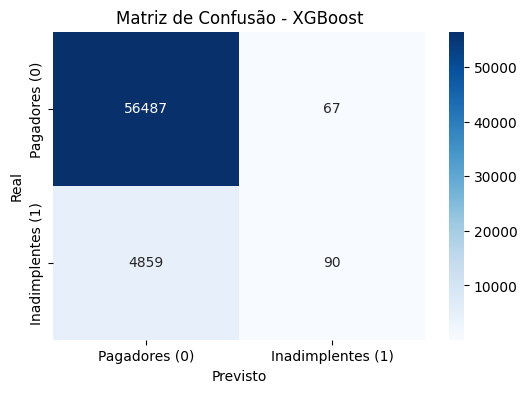

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Criar matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pagadores (0)", "Inadimplentes (1)"], yticklabels=["Pagadores (0)", "Inadimplentes (1)"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost")
plt.show()


In [9]:
cm

array([[56487,    67],
       [ 4859,    90]])

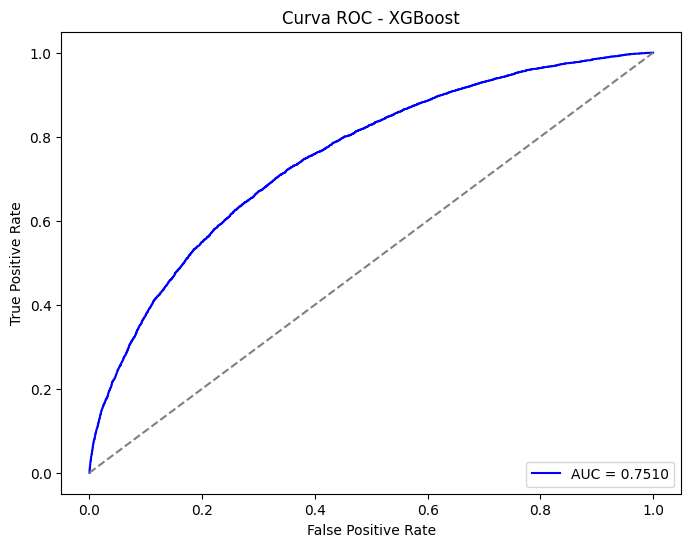

In [10]:
from sklearn.metrics import roc_curve, auc

# Gerar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Linha base

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - XGBoost")
plt.legend(loc="lower right")
plt.show()



Nota: Percebe-se claramente que o modelo (mesmo sendo o xgboost que, teoricamente, lida bem com desbalanceamento das classes) ainda está enviesado para a classe majoritária (0) já que tem um recall muito alto.

# Ajustes para tentar melhorar o modelo

In [11]:
# Calcular a proporção entre as classes
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"🔹 scale_pos_weight calculado: {scale_pos_weight:.2f}")


🔹 scale_pos_weight calculado: 11.38


In [12]:
# Criar e treinar o modelo XGBoost com balanceamento
xgb_model_balanced = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # Balanceamento da classe 1
    random_state=42
)

xgb_model_balanced.fit(X_train, y_train)

# Fazer previsões
y_pred_balanced = xgb_model_balanced.predict(X_test)
y_pred_prob_balanced = xgb_model_balanced.predict_proba(X_test)[:, 1]


In [13]:
# Avaliação do modelo com scale_pos_weight
print("🔹 Accuracy Score:", accuracy_score(y_test, y_pred_balanced))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_balanced))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_balanced))


🔹 Accuracy Score: 0.7085345430304213

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     56554
           1       0.17      0.65      0.27      4949

    accuracy                           0.71     61503
   macro avg       0.56      0.68      0.54     61503
weighted avg       0.90      0.71      0.77     61503


🔹 ROC AUC Score: 0.7510528849868618


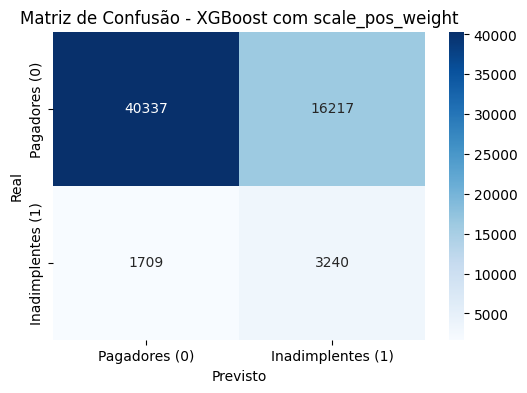

In [14]:
# Criar matriz de confusão
cm = confusion_matrix(y_test, y_pred_balanced)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pagadores (0)", "Inadimplentes (1)"], yticklabels=["Pagadores (0)", "Inadimplentes (1)"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost com scale_pos_weight")
plt.show()


In [15]:
cm

array([[40337, 16217],
       [ 1709,  3240]])

Esse ajuste teve um grande impacto na detecção dos inadimplentes (1) porém reduziu a acurácia, o recall de 2% subiu para 65%, além disso o ROC AUC ficou estável (apesar de que um valor ideal seria em torno de 85% pra mais)

#### Hiper-parâmetros Xgboost

Valores manuais:

In [16]:
# Importação da biblioteca
from xgboost import XGBClassifier

# Ajuste inicial dos hiperparâmetros
xgb_tuned = XGBClassifier(
    n_estimators=300,        # Aumentar número de árvores
    learning_rate=0.05,      # Reduzindo taxa de aprendizado
    max_depth=8,             # Aumentando a profundidade da árvore
    min_child_weight=5,      # Aumentar para evitar overfitting
    subsample=0.8,           # Reduzindo amostras usadas por árvore
    colsample_bytree=0.8,    # Reduzindo features usadas por árvore
    gamma=0.2,               # Adicionando penalização para evitar overfitting
    scale_pos_weight=scale_pos_weight,  # Balanceamento da classe 1
    random_state=42,
    use_label_encoder=False
)

# Treinar o modelo ajustado
xgb_tuned.fit(X_train, y_train)

# Fazer previsões
y_pred_tuned = xgb_tuned.predict(X_test)
y_pred_prob_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

# Avaliação do modelo ajustado
print("🔹 Accuracy Score:", accuracy_score(y_test, y_pred_tuned))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_tuned))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_tuned))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:18:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔹 Accuracy Score: 0.7587597352974652

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.86     56554
           1       0.18      0.58      0.28      4949

    accuracy                           0.76     61503
   macro avg       0.57      0.68      0.57     61503
weighted avg       0.89      0.76      0.81     61503


🔹 ROC AUC Score: 0.7478680103987861


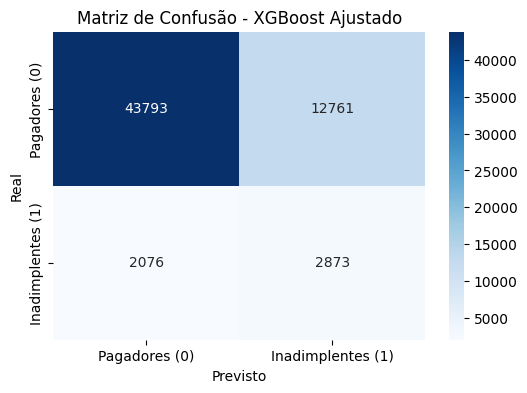

🔹 Matriz de Confusão:
[[43793 12761]
 [ 2076  2873]]


In [17]:
# Criar matriz de confusão
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

# Visualizar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues", xticklabels=["Pagadores (0)", "Inadimplentes (1)"], yticklabels=["Pagadores (0)", "Inadimplentes (1)"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost Ajustado")
plt.show()

# Exibir valores da matriz de confusão
print("🔹 Matriz de Confusão:")
print(cm_tuned)

Com os hiperparâmetros ajustados manualmente, tivemos um recall melhor , porém agora o modelo está classificando erroneamente pagadores como inadimplentes (12761), além disso a precisão da classe 1 está muito baixa

#### Valores com RandomizedSearchCV

In [19]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Criar o modelo base
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Definir os hiperparâmetros para o RandomizedSearchCV
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Criar o Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,  # Reduz para apenas 10 combinações aleatórias
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Ajustar o modelo ao conjunto de treinamento
random_search.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros
print("🔹 Melhores Hiperparâmetros:", random_search.best_params_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:24:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔹 Melhores Hiperparâmetros: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}


In [20]:
# Criar e treinar o modelo com os melhores hiperparâmetros
xgb_tuned = XGBClassifier(
    subsample=1.0,
    n_estimators=100,
    min_child_weight=5,
    max_depth=6,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # Mantendo o balanceamento de classes
    random_state=42,
    eval_metric="logloss"
)

xgb_tuned.fit(X_train, y_train)

# Fazer previsões
y_pred_tuned = xgb_tuned.predict(X_test)


In [21]:
print("\n🔹 Accuracy Score:", accuracy_score(y_test, y_pred_tuned))
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred_tuned))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_tuned))


🔹 Accuracy Score: 0.7080142432076484

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56554
           1       0.17      0.66      0.27      4949

    accuracy                           0.71     61503
   macro avg       0.56      0.68      0.54     61503
weighted avg       0.90      0.71      0.77     61503


🔹 ROC AUC Score: 0.684232835136949


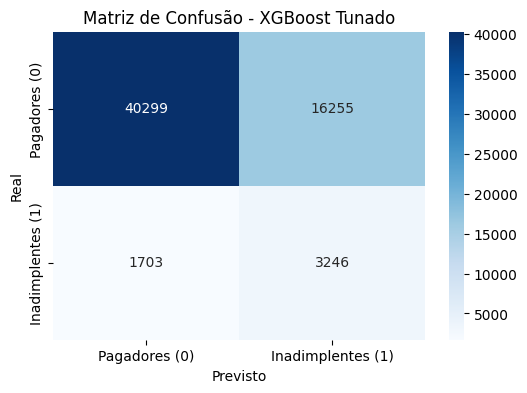

array([[40299, 16255],
       [ 1703,  3246]])

In [22]:
cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pagadores (0)", "Inadimplentes (1)"], yticklabels=["Pagadores (0)", "Inadimplentes (1)"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost Tunado")
plt.show()

cm

tivemos uma melhora no recall da classe 1, o f1 score subiu levemente e tivemos uma melhor separação entre classes, entretanto, ainda temos:
Valor alto para falsos positivos
Acurácia geral caiu
o ROC AUC caiu também, ficando um valor baix

# Testando o LightGBM

In [ ]:
#!pip install "dask[dataframe]"


In [23]:
# Importar o LightGBM
from lightgbm import LGBMClassifier

# Criar e treinar o modelo LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=100,  # Número de árvores (ajustável)
    learning_rate=0.1,  # Taxa de aprendizado
    max_depth=6,  # Profundidade máxima da árvore
    min_child_weight=5,  # Controle de overfitting
    colsample_bytree=0.8,  # Fração de colunas usadas por árvore
    subsample=1.0,  # Fração de amostras usadas por árvore
    random_state=42,
    class_weight='balanced'  # Balanceamento automático das classes
)

In [24]:
# Treinar o modelo
lgbm_model.fit(X_train, y_train)

# Fazer previsões
y_pred_lgbm = lgbm_model.predict(X_test)

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5176
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


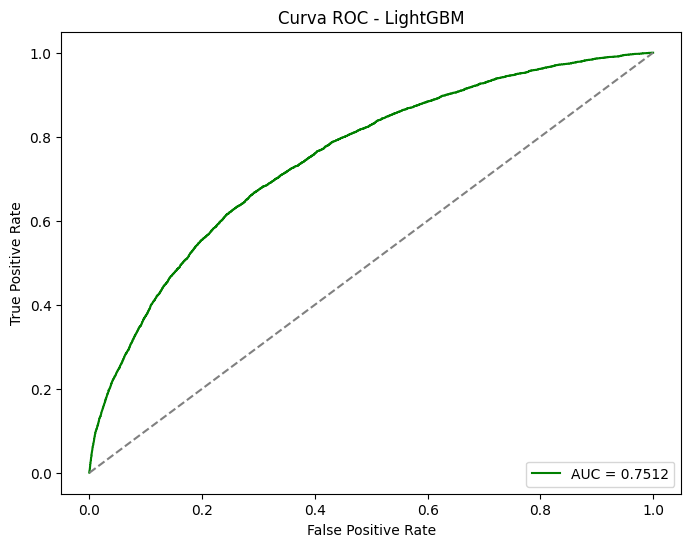

In [37]:
# Gerar probabilidades preditas (probabilidade da classe 1)
y_pred_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Gerar curva ROC
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_prob_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, label=f"AUC = {roc_auc_lgbm:.4f}", color="green")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Linha base

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - LightGBM")
plt.legend(loc="lower right")
plt.show()



🔹 Accuracy Score: 0.6993479992845878

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.16      0.67      0.26      4949

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503


🔹 ROC AUC Score: 0.6867112982595405


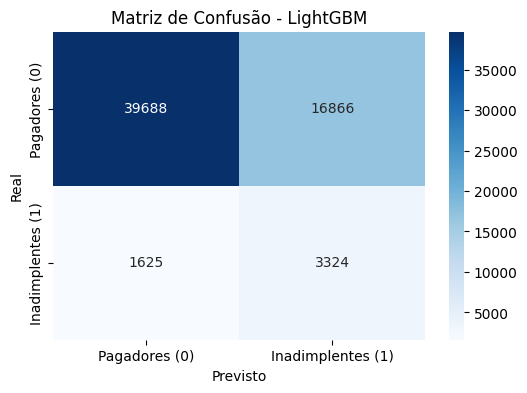

array([[39688, 16866],
       [ 1625,  3324]])

In [26]:
#Exibir métricas do modelo LightGBM
print("\n🔹 Accuracy Score:", accuracy_score(y_test, y_pred_lgbm))
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred_lgbm))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_lgbm))

#Criar a Matriz de Confusão para LightGBM
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(6,4))
sns.heatmap(cm_lgbm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pagadores (0)", "Inadimplentes (1)"], yticklabels=["Pagadores (0)", "Inadimplentes (1)"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - LightGBM")
plt.show()

cm_lgbm

#### Tentativa de Ajustes (LightGBM)

In [28]:
scale_pos_weight


11.377138257194607

In [29]:
lgbm_model_opt = LGBMClassifier(
    n_estimators=500,  # Aumentamos o número de árvores
    learning_rate=0.05,  # Taxa de aprendizado menor para melhor convergência
    max_depth=8,  # Permite capturar mais padrões
    min_child_weight=3,  # Regularização para evitar overfitting
    colsample_bytree=0.8,  # Fracionamento das features
    subsample=0.8,  # Subamostragem para evitar overfitting
    reg_alpha=0.1,  # Regularização L1
    reg_lambda=0.2,  # Regularização L2
    scale_pos_weight=scale_pos_weight,  # Balanceamento da classe
    random_state=42
)

# 📌 Treinar o modelo
lgbm_model_opt.fit(X_train, y_train)

# 📌 Fazer previsões
y_pred_lgbm_opt = lgbm_model_opt.predict(X_test)

print("\n🔹 Accuracy Score:", accuracy_score(y_test, y_pred_lgbm_opt))
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred_lgbm_opt))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_lgbm_opt))

# 📌 Criar a Matriz de Confusão
cm_lgbm_opt = confusion_matrix(y_test, y_pred_lgbm_opt)

cm_lgbm_opt

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5176
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606

🔹 Accuracy Score: 0.713688763149765

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56554
           1       0.17      0.66      0.27      4949

    accuracy                           0.71     61503
   macro avg       0.56      0.69      0.55     61503
weighted avg       0.90      0.71      0.78     61503


🔹 ROC AUC Score: 0.6883324651338264


array([[40637, 15917],
       [ 1692,  3257]])

Tive uma melhora na separação das classes, a acurácia melhorou um pouco o recall e o f1 score manteve e o ROC aumentou muito pouco

Hiperparâmetros LightGBM com RandomizedSearchCV

In [30]:
from sklearn.model_selection import RandomizedSearchCV

# 📌 Definir a grade de hiperparâmetros para otimização
param_grid_lgbm = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# 📌 Criar o modelo base
lgbm_model_base = LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# 📌 Criar o RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model_base,
    param_distributions=param_grid_lgbm,
    n_iter=10,  # Testaremos 10 combinações aleatórias
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 📌 Ajustar o modelo ao conjunto de treinamento
random_search_lgbm.fit(X_train, y_train)

# 📌 Exibir os melhores hiperparâmetros
print("🔹 Melhores Hiperparâmetros LightGBM:", random_search_lgbm.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5176
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [31]:
#Importar biblioteca necessária
from lightgbm import LGBMClassifier

#Criar o modelo LightGBM otimizado
lgbm_final = LGBMClassifier(
    subsample=1.0,
    reg_lambda=0.1,
    reg_alpha=0.5,
    n_estimators=300,
    min_child_weight=3,
    max_depth=6,
    learning_rate=0.05,
    colsample_bytree=0.6,
    scale_pos_weight=scale_pos_weight,  # Balanceamento da classe
    random_state=42
)

#Treinar o modelo
lgbm_final.fit(X_train, y_train)

#Fazer previsões no conjunto de teste
y_pred_lgbm_final = lgbm_final.predict(X_test)


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5176
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



🔹 Accuracy Score: 0.7046810724680097

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56554
           1       0.17      0.67      0.27      4949

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503


🔹 ROC AUC Score: 0.6882283405029137


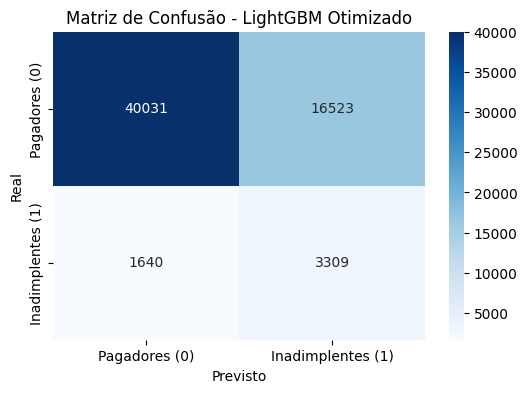

array([[40031, 16523],
       [ 1640,  3309]])

In [32]:
#Exibir métricas do modelo final
print("\n🔹 Accuracy Score:", accuracy_score(y_test, y_pred_lgbm_final))
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred_lgbm_final))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_lgbm_final))

#Criar a Matriz de Confusão
cm_lgbm_final = confusion_matrix(y_test, y_pred_lgbm_final)

plt.figure(figsize=(6,4))
sns.heatmap(cm_lgbm_final, annot=True, fmt="d", cmap="Blues", xticklabels=["Pagadores (0)", "Inadimplentes (1)"], yticklabels=["Pagadores (0)", "Inadimplentes (1)"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - LightGBM Otimizado")
plt.show()

cm_lgbm_final

Melhoramos um pouco o recall , porém a acurácia caiu e ainda temos muito falsos positivos em geral

# Bônus: Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [34]:
# 📌 Criando o modelo Random Forest com hiperparâmetros ajustados
rf_model = RandomForestClassifier(
    n_estimators=300,      # Número de árvores na floresta
    max_depth=10,          # Profundidade máxima das árvores
    min_samples_split=5,   # Mínimo de amostras para dividir um nó
    min_samples_leaf=3,    # Mínimo de amostras em uma folha
    max_features="sqrt",   # Número de features consideradas em cada divisão
    class_weight="balanced",  # Balanceamento das classes automaticamente
    random_state=42,
    n_jobs=-1,             # Usa todos os processadores disponíveis
    verbose=1
)

# 📌 Treinar o modelo
rf_model.fit(X_train, y_train)

# 📌 Fazer previsões no conjunto de teste
y_pred_rf = rf_model.predict(X_test)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.7s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.8s finished


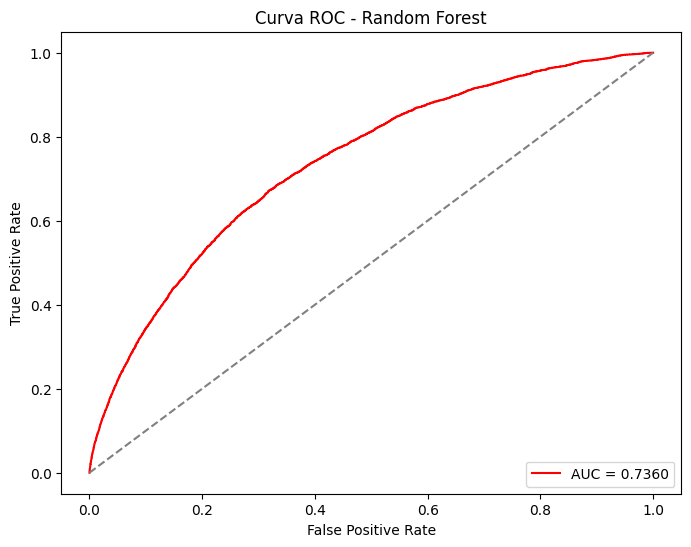

In [38]:
# Gerar probabilidades preditas
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Gerar curva ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {roc_auc_rf:.4f}", color="red")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Linha base

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Random Forest")
plt.legend(loc="lower right")
plt.show()



🔹 Accuracy Score: 0.7202738077817342

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56554
           1       0.17      0.62      0.26      4949

    accuracy                           0.72     61503
   macro avg       0.56      0.67      0.55     61503
weighted avg       0.89      0.72      0.78     61503


🔹 ROC AUC Score: 0.6743049376297998


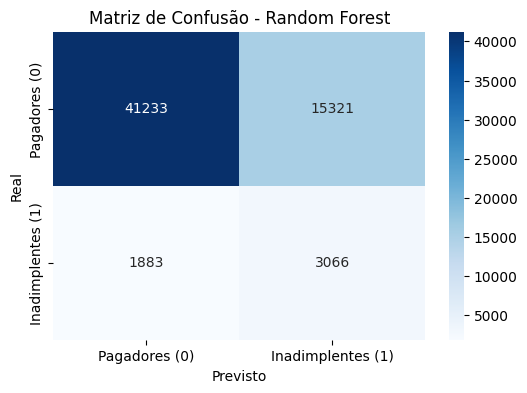

In [35]:
# Exibir métricas do modelo Random Forest
print("\n🔹 Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))

# Criar a Matriz de Confusão
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Pagadores (0)", "Inadimplentes (1)"], yticklabels=["Pagadores (0)", "Inadimplentes (1)"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Random Forest")
plt.show()


In [36]:
cm_rf

array([[41233, 15321],
       [ 1883,  3066]])

Principais Observações
Acurácia: 72.0% das previsões foram corretas, indicando um bom desempenho geral do modelo.
Recall para inadimplentes (classe 1): 62% dos inadimplentes foram corretamente identificados, ou seja, 38% ainda estão sendo classificados erroneamente como bons pagadores.
Falsos positivos (clientes bons classificados como ruins): 15.321 clientes foram marcados erroneamente como inadimplentes.
Falsos negativos (clientes ruins classificados como bons): 3.066 inadimplentes foram erroneamente aprovados.



# Comparando resultados entre os modelos